In [14]:
import os
import sys
import pandas as pd

DATASET_TAGS = {
	'tabula-muris-heart': 'Tabula Muris Heart',
	'tabula-muris-marrow_P7_3': 'Tabula Muris Marrow',
	'peripheral-blood': '5kPBMC',
	'zheng-4': 'Zhengmix4eq',
	'zheng-8': 'Zhengmix8eq'
}

DATASET_ORDER = {
	'tabula-muris-heart': 1,
	'tabula-muris-marrow_P7_3': 2,
	'peripheral-blood': 3,
	'zheng-4': 4,
	'zheng-8': 5
}

TOOL_TAGS = {
	'COTAN': 'COTAN',
	'seurat': 'Seurat',
	'scanpy': 'Scanpy',
	'monocle':'Monocle',
	'scvi-tools': 'scvi-tools',
    'all': 'RF Base'
}

path = '../results/aggregate/{}/clf_f1.csv'
found_datasets = []
showPlot = not sys.argv[2].endswith('False')

scores_df = pd.DataFrame(columns=['f1', 'tool', 'dataset'])
for dataset in DATASET_TAGS.keys():
	file_path = path.format(dataset)
	# check file existence
	if os.path.isfile(file_path):
		found_datasets.append(DATASET_TAGS[dataset])
		df = pd.read_csv(file_path, index_col=0)
		df['tool'] = df.index
		df['dataset'] = dataset
		scores_df = pd.concat([scores_df, df])
	
scores_df['dataset_pos'] = scores_df['dataset']
tool_count = len(scores_df['tool'].unique())

# replace dataset pos with map of DATASET_ORDER
scores_df['dataset_pos'] = scores_df['dataset_pos'].map(DATASET_ORDER)

In [15]:
##### plot

import matplotlib.pyplot as plt
import numpy as np

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('Set2').colors)

SCORES = ['f1']

score_dict = {}
for score in SCORES:
	means = {}
	# round scores to 3 decimal places
	scores_df[score] = scores_df[score].apply(lambda x: round(x, 3))

	for tool in TOOL_TAGS.keys():
		tool_scores = scores_df[scores_df['tool'] == tool]
		if not tool_scores.empty:
			tool_scores = tool_scores.sort_values(by='dataset_pos')
			# generate tuple of scores for each dataset in order
			means[TOOL_TAGS[tool]] = tuple(x for x in tool_scores[score])
	score_dict[score] = means

In [16]:
def score_bar_plot(data, found_datasets, tool_count, score, percentage=True):
    means = data[score]
    x = np.arange(len(found_datasets))  # the label locations
    width = 1/(tool_count+1)  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(16,9))
    max_height = 1
    min_height = 0

    for attribute, measurement in means.items():
        # max in mesurement
        if percentage:
            measurement = tuple(x * 100 for x in measurement)
        max_measurement = max(measurement)
        if max_measurement > max_height:
            max_height = max_measurement
        min_measurement = min(measurement)
        if min_measurement < min_height:
            min_height = min_measurement

        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=-15)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    if percentage:
        ax.set_ylabel('{} Score (%)'.format(score), fontsize=16)
    else:
        ax.set_ylabel('Score')
    ax.set_xticks(x + width, found_datasets, fontsize=14)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    ax.set_ylim(min_height*1, max_height*1)

    plt.savefig("../results/clf_allFeatures_vs_50.eps", format="eps", bbox_inches='tight')
    plt.savefig("../results/clf_allFeatures_vs_50.png", format="png", bbox_inches='tight')

    if showPlot: plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


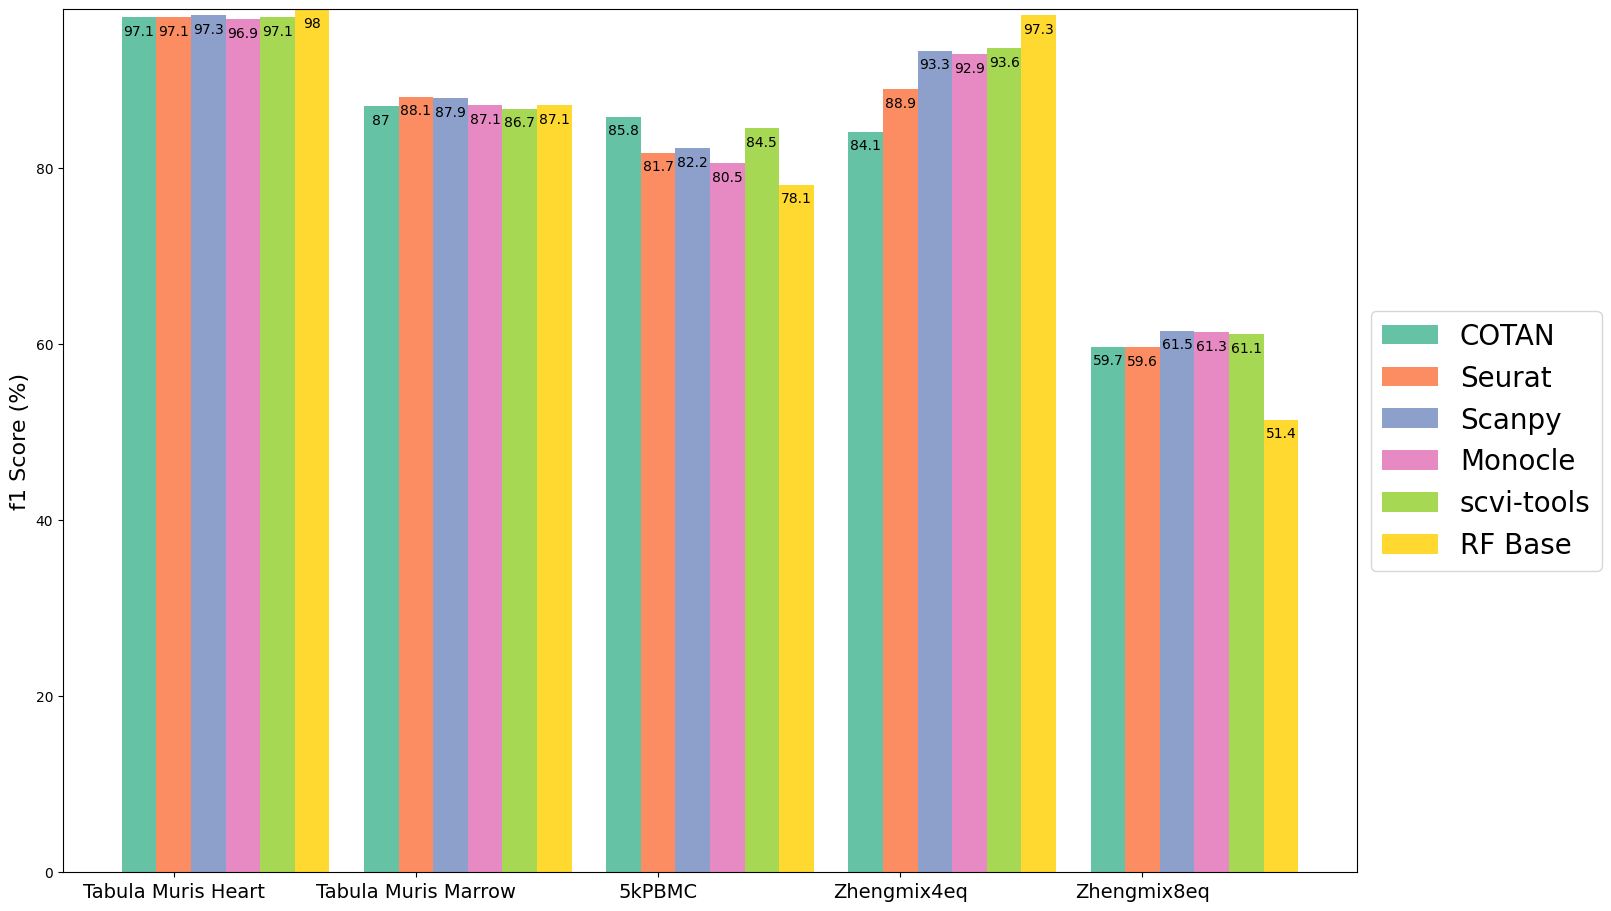

In [17]:
score_bar_plot(score_dict, found_datasets, tool_count, score='f1')